<a href="https://colab.research.google.com/github/antoniovfonseca/compare-deforestation-maps/blob/main/falseAlarm_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install openpyxl to read Excel files
!pip install openpyxl -q

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl

In [3]:
# Load the Excel file directly from GitHub
url = "https://raw.githubusercontent.com/antoniovfonseca/compare-deforestation-maps/main/prodesMapbiomas.xlsx"
df = pd.read_excel(url)

In [4]:
# Extract PRODES and MapBiomas years based on the coding rule
df["prodes_year"] = df["Value"] // 10000
df["mapbiomas_year"] = df["Value"] % 10000

In [5]:
def classify_row(row):
    if row["prodes_year"] == 0 and row["mapbiomas_year"] == 0:
        return "Correct Rejection"
    elif row["prodes_year"] == row["mapbiomas_year"]:
        return "Hit"
    elif row["prodes_year"] != 0 and row["mapbiomas_year"] == 0:
        return "Miss"
    else:
        return "False Alarm"

df["classification"] = df.apply(classify_row, axis=1)

In [6]:
def characterize_false_alarm(row):
    if row["classification"] != "False Alarm":
        return np.nan
    elif row["prodes_year"] == 0:
        return "Only MapBiomas"
    else:
        return row["mapbiomas_year"] - row["prodes_year"]

df["false_alarm_detail"] = df.apply(characterize_false_alarm, axis=1)


In [9]:
# Show the final DataFrame
df.head(20)  # You can change the number to show more rows

,Value,Count,prodes_year,mapbiomas_year,classification,false_alarm_detail
0,0,10720861602,0,0,Correct Rejection,NaN
1,2008,9129284,0,2008,False Alarm,Only MapBiomas
2,2009,5551766,0,2009,False Alarm,Only MapBiomas
3,2010,4670382,0,2010,False Alarm,Only MapBiomas
4,2011,4618504,0,2011,False Alarm,Only MapBiomas
5,2012,4028942,0,2012,False Alarm,Only MapBiomas
6,2013,4620024,0,2013,False Alarm,Only MapBiomas
7,2014,4096307,0,2014,False Alarm,Only MapBiomas
8,2015,4517393,0,2015,False Alarm,Only MapBiomas
9,2016,5333721,0,2016,False Alarm,Only MapBiomas


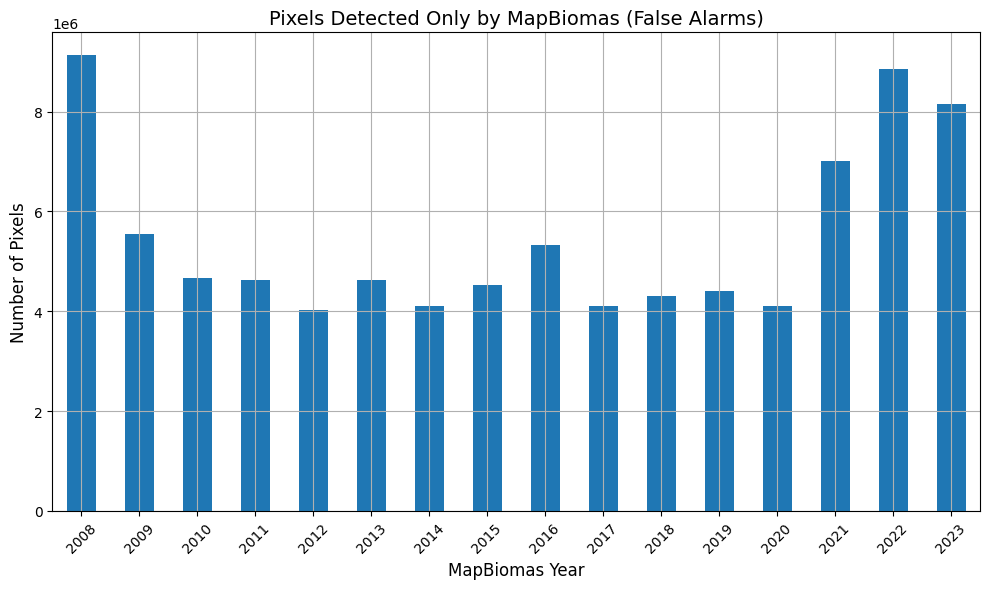

In [11]:
# Filter rows where only MapBiomas detected deforestation
only_mapbiomas = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] == 0)]

# Group by MapBiomas year and sum the number of pixels
pixels_per_year = only_mapbiomas.groupby('mapbiomas_year')['Count'].sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
pixels_per_year.plot(kind='bar')
plt.title('Pixels Detected Only by MapBiomas (False Alarms)', fontsize=14)
plt.xlabel('MapBiomas Year', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



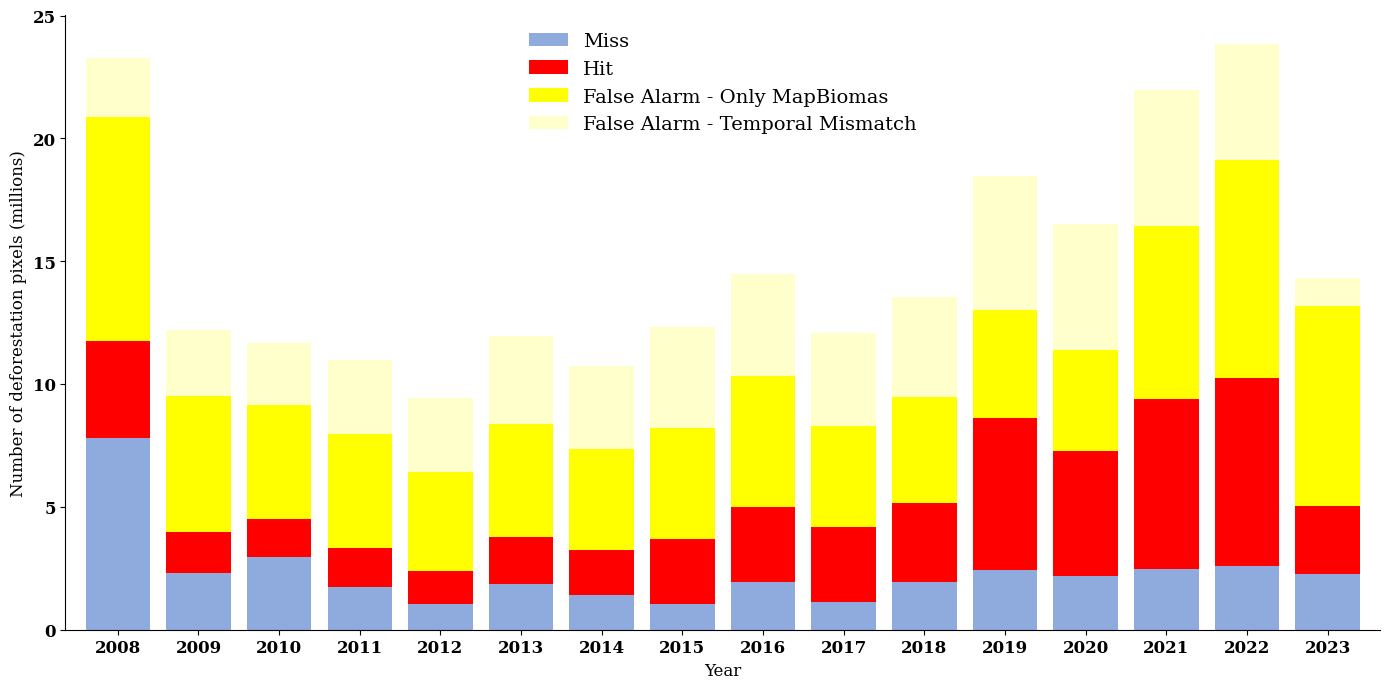

In [39]:
# Set Times New Roman as the global font
mpl.rcParams['font.family'] = 'serif'

# Define custom colors for each category
colors = {
    "Miss": "#8FAADC",
    "Hit": "#FF0000",
    "False Alarm - Only MapBiomas": "#FFFF00",
    "False Alarm - Temporal Mismatch": "#FFFFCC"
}

# Filter and group data
miss = df[(df['classification'] == 'Miss') & (df['prodes_year'] != 0)]
miss_grouped = miss.groupby('prodes_year')['Count'].sum()

hit = df[df['classification'] == 'Hit'].groupby('mapbiomas_year')['Count'].sum()

fa_only = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] == 0)].groupby('mapbiomas_year')['Count'].sum()
fa_diff = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] != 0)].groupby('mapbiomas_year')['Count'].sum()

# Combine all classes in a single DataFrame
stacked = pd.concat([
    miss_grouped.rename("Miss"),
    hit.rename("Hit"),
    fa_only.rename("False Alarm - Only MapBiomas"),
    fa_diff.rename("False Alarm - Temporal Mismatch")
], axis=1).fillna(0).astype(int)

stacked = stacked.sort_index()

# Plot with custom colors
stacked[["Miss",
         "Hit",
         "False Alarm - Only MapBiomas",
         "False Alarm - Temporal Mismatch"]].plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    width=0.8,
    color=[
        colors["Miss"],
        colors["Hit"],
        colors["False Alarm - Only MapBiomas"],
        colors["False Alarm - Temporal Mismatch"]
    ]
)

# plt.title("Pixel Classification per Year", fontsize=14)
plt.xticks(
    rotation=0,
    fontweight='bold',
    fontsize=12
           )
plt.yticks(
    rotation=0,
    fontweight='bold',
    fontsize=12
           )
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}'))
plt.legend(frameon=False,
           title=None,
           fontsize=14)
# Remove all outer frame lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

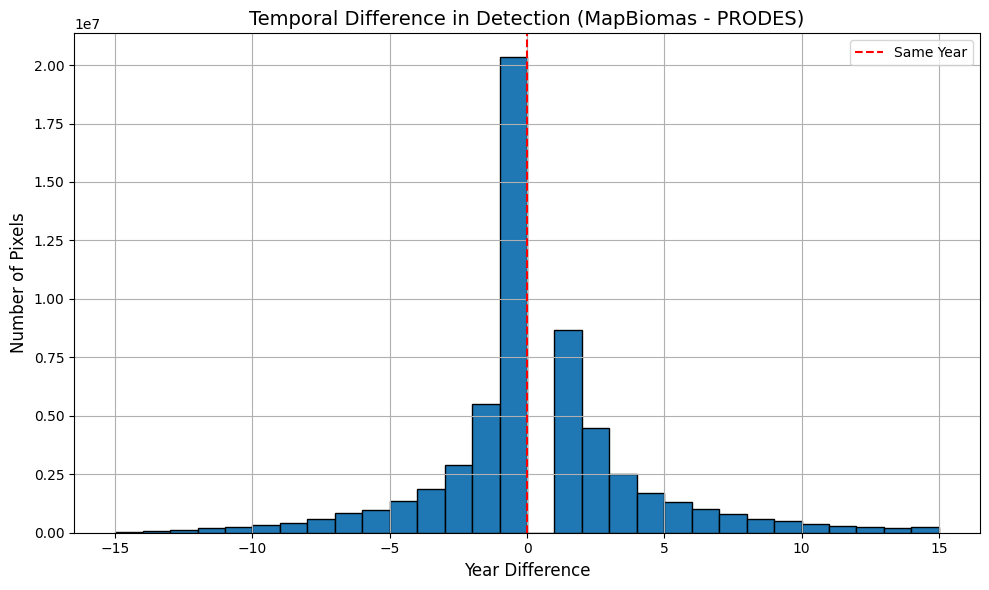

In [12]:
# Filter rows where both maps detected deforestation but in different years
# Only consider False Alarms where PRODES also detected, but in a different year
diff_years = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] != 0)]

# Repeat the temporal difference values according to pixel count
# Needed to properly weight each bin in the histogram
diff_values = diff_years['false_alarm_detail'].astype(int).repeat(diff_years['Count'])

# Create a histogram of year differences
plt.figure(figsize=(10, 6))
plt.hist(diff_values, bins=range(diff_values.min(), diff_values.max() + 1), edgecolor='black')
plt.title('Temporal Difference in Detection (MapBiomas - PRODES)', fontsize=14)
plt.xlabel('Year Difference', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)
plt.axvline(0, color='red', linestyle='--', label='Same Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
